In [ ]:
!pip install mediapipe opencv-python

     |████████████████████████████████| 30.4 MB 74 kB/s 


In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd

mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

In [ ]:
from google.colab import drive # 국방부 해커톤/input에 있는 영상 사본 만들고 사본을 옮겨서 이름 바꾸기 / 원본 안옮기게 주의!
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# **Finding XYZ**

In [ ]:
def find_xyz(ind_list, landmark):
  a = landmark[ind_list[0]]
  b = landmark[ind_list[1]]
  c = landmark[ind_list[2]]

  first = [a.x,a.y,a.z,a.visibility]
  mid = [b.x,b.y,b.z,b.visibility]
  end = [c.x,c.y,c.z,c.visibility]
  return first, mid, end

# **Calculating Angle**

In [ ]:
def calculate_angle3D_left(a,b,c):
  """
  Video(photo) for a person's left side
  calculate_angle3D is divided by left and right side because this function uses external product
  input : landmark with shape [x,y,z,visibility]
  output : angle between ba and bc with range 0~360
  """
  a = a[:3]
  b = b[:3]
  c = c[:3]
  # external product's z value
  external_z = (b[0]-a[0])*(b[1]-c[1]) - (b[1]-a[1])*(b[0]-c[0])

  a = np.array(a) #first
  b = np.array(b) #mid
  c = np.array(c) #end

  ba = b-a
  bc = b-c
  dot_result = np.dot(ba, bc)


  ba_size = np.linalg.norm(ba)
  bc_size = np.linalg.norm(bc)
  radi = np.arccos(dot_result / (ba_size*bc_size))
  angle = np.abs(radi*180.0/np.pi)

  # left side
  if external_z < 0:
    angle = 360 - angle

  return angle


In [ ]:
def calculate_angle3D_right(a,b,c):
  """
  Video(photo) for a person's right side
  calculate_angle3D is divided by left and right side because this function uses external product
  input : landmark with shape [x,y,z,visibility]
  output : angle between ba and bc with range 0~360
  """
  a = a[:3]
  b = b[:3]
  c = c[:3]
  # external product's z value
  external_z = (b[0]-a[0])*(b[1]-c[1]) - (b[1]-a[1])*(b[0]-c[0])

  a = np.array(a) #first
  b = np.array(b) #mid
  c = np.array(c) #end

  ba = b-a
  bc = b-c
  dot_result = np.dot(ba, bc)


  ba_size = np.linalg.norm(ba)
  bc_size = np.linalg.norm(bc)
  radi = np.arccos(dot_result / (ba_size*bc_size))
  angle = np.abs(radi*180.0/np.pi)
  
  # right side
  if external_z > 0:
    angle = 360 - angle

  return angle


# **Checking Angle(xyz)**

In [ ]:
counter = 0
stage = None
video_path = "/content/good/4.mp4"
cap = cv2.VideoCapture(video_path)

#우측 관절값
joint_indx = {'check_right_elbow':[16,14,12],'check_right_shoulder':[14,12,24],'check_right_hip':[12,24,26],'check_right_knee':[24,26,28],
              'check_left_elbow':[15,13,11],'check_left_shoulder':[13,11,23],'check_left_hip':[11,23,25],'check_left_knee':[23,25,27]} 
save_angle3D = {'check_right_elbow':[],'check_right_shoulder':[],'check_right_hip':[],'check_right_knee':[],
                'check_left_elbow':[],'check_left_shoulder':[],'check_left_hip':[],'check_left_knee':[]}
vis_dict = {'check_right_elbow':[],'check_right_shoulder':[],'check_right_hip':[],'check_right_knee':[],
                'check_left_elbow':[],'check_left_shoulder':[],'check_left_hip':[],'check_left_knee':[]}
weighted_angle3D = {'elbow': [], 'shoulder' : [], 'hip' : [], 'knee':[]}


if cap.isOpened():
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    res=(int(width), int(height))
    fourcc = cv2.VideoWriter_fourcc(*'MP4V') #codec
    out = cv2.VideoWriter('bandi.mp4', fourcc, 20.0, res)

    frame = None
    while True:
      try:
        ret, frame = cap.read()
      except cv2.error:
        continue
      if not ret:
        break

      image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
      results = pose.process(image)

      if results.pose_landmarks:
        mp_drawing.draw_landmarks(frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
        for id, im in enumerate(results.pose_landmarks.landmark):
          h, w, c = frame.shape
          cx, cy = int(im.x*w), int(im.y*h)
          cv2.circle(frame, (cx,cy), 5, (255, 0, 0), cv2.FILLED)
        landmark = results.pose_landmarks.landmark
        for key,val in joint_indx.items():
          first,mid,end = find_xyz(val, landmark)
          vis_dict[key].append(first[3] + mid[3]+ end[3])
          vis_dict[key].append(first[3] + mid[3]+ end[3])
          angle = calculate_angle3D_right(first,mid,end) #각도 계산
          mid = mid[0:2]
          cv2.putText(frame, str(angle),tuple(np.multiply(mid, [2400,1080]).astype(int)),cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255,0,0),5,cv2.LINE_AA)
          save_angle3D[key].append(angle)
          
 
      out.write(frame)
    out.release()



# **Weighted angle by using visibility**

In [ ]:
# The Higher visibility, the more influence on calculating angle.
L = len(save_angle3D['check_right_elbow'])

for i in range(L):
  a = vis_dict['check_right_elbow'][i]
  b = vis_dict['check_left_elbow'][i]
  weighted_angle3D['elbow'].append(a/(a+b)*save_angle3D['check_right_elbow'][i]
                                   + b/(a+b)*save_angle3D['check_left_elbow'][i])
for i in range(L):
  a = vis_dict['check_right_shoulder'][i]
  b = vis_dict['check_left_shoulder'][i]
  weighted_angle3D['shoulder'].append(a/(a+b)*save_angle3D['check_right_shoulder'][i]
                                   + b/(a+b)*save_angle3D['check_left_shoulder'][i])
for i in range(L):
  a = vis_dict['check_right_hip'][i]
  b = vis_dict['check_left_hip'][i]
  weighted_angle3D['hip'].append(a/(a+b)*save_angle3D['check_right_hip'][i]
                                   + b/(a+b)*save_angle3D['check_left_hip'][i])
for i in range(L):
  a = vis_dict['check_right_knee'][i]
  b = vis_dict['check_left_knee'][i]
  weighted_angle3D['knee'].append(a/(a+b)*save_angle3D['check_right_knee'][i]
                                   + b/(a+b)*save_angle3D['check_left_knee'][i])

# **Visualizing Angle Value(xyz)**

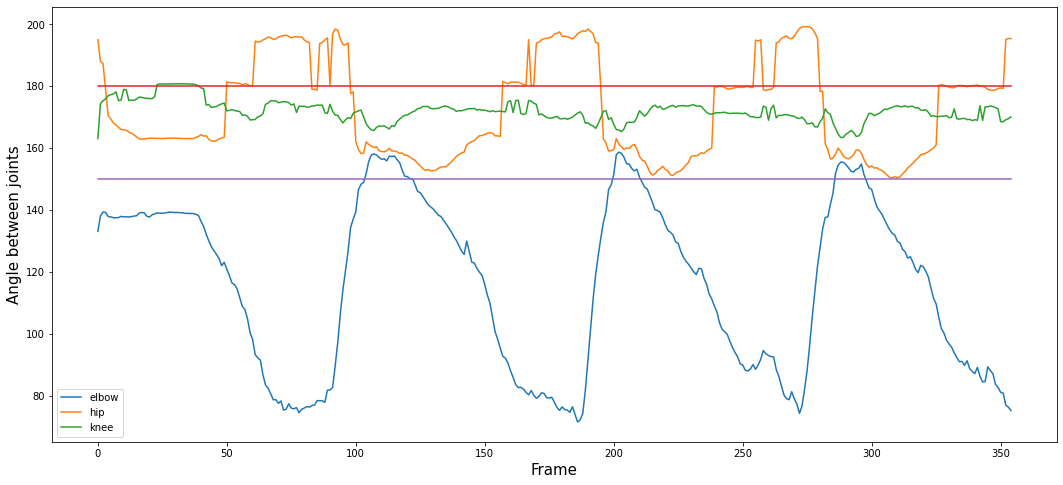

In [ ]:
import matplotlib.pyplot as plt

a = [180 for i in range(L)]
b = [150 for i in range(L)]

plt.figure(figsize=(18,8))
plt.xlabel('Frame', fontsize=15)
plt.ylabel('Angle between joints', fontsize=15)

for key in weighted_angle3D.keys():
  # shoulder isn't that important in pushups
  if key != 'shoulder':
    plt.plot(weighted_angle3D[key], label=key)

plt.plot(a)
plt.plot(b)

leg = plt.legend(loc='best')

plt.savefig('4.jpg', dpi=300)

# **Feedback to Pose (Not Done yet)**

In [ ]:
elbow_list = weighted_angle3D['elbow']
# min_val = [80]
below = False
below_cnt = 0
up = False
up_cnt = 0
for i in range(L):
  if not below and elbow_list[i] < 80:
    below = True
    below_cnt += 1
  if below and elbow_list[i] > 90:
    below = False
  if not up and elbow_list[i] > 150:
    up = True
    up_cnt += 1
  if up and elbow_list[i] < 140:
    up = False

below_cnt
# print([i for i in range(L) if elbow_list[i] == 80])
# elbow_list

4

In [ ]:
from google.colab import files
files.download('bandi.mp4')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>